In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dir_list = {
    0: '../data/Trends Smart City/0EG/',
    1: '../data/Trends Smart City/1OG/',
    2: '../data/Trends Smart City/2OG/',
    3: '../data/Trends Smart City/3OG/'
}
file_list = {
    0: os.listdir(dir_list[0]),
    1: os.listdir(dir_list[1]),
    2: os.listdir(dir_list[2]),
    3: os.listdir(dir_list[3])
}

In [46]:
START_FEEDBACK_PERIOD = '2022-09-12' # Begin of the school year in styria

rooms_temp = []
rooms_temp_list = []
rooms_temp_feedback_period = []
names_temp = []
rooms_qual = []
rooms_qual_list = []
rooms_qual_feedback_period = []
names_qual = []

for floor in dir_list.keys():
    for file in file_list[floor]:
        room_name = file.split()[0]
        room_df = pd.read_csv(
            dir_list[floor] + file,
            sep=';',
            parse_dates=True,
            header=0,
            index_col=0,
            names=[room_name, '_1', '_2', '_3'],
            )
        room_df.index.name = 'Time'
        room_df['Minute'] = room_df.index.hour * 60 + room_df.index.minute
        if file.split()[1][:-4] == 'Lufttemp':
            names_temp.append(room_name)
            rooms_temp.append(room_df.iloc[:,[0, -1]].dropna())
            rooms_temp_feedback_period.append(room_df.loc[START_FEEDBACK_PERIOD:,[room_name, 'Minute']].dropna())
            #rooms_temp_list.append(room_df.iloc[:,0].dropna().tolist())
        else:
            names_qual.append(room_name)
            rooms_qual.append(room_df.iloc[:,[0, -1]].dropna())
            rooms_qual_feedback_period.append(room_df.loc[START_FEEDBACK_PERIOD:,[room_name, 'Minute']].dropna())
            #rooms_qual_list.append(room_df.iloc[:,0].dropna().tolist())

In [47]:
rooms_data = [rooms_temp, rooms_qual]
#rooms_data_list = [rooms_temp_list, rooms_qual_list]
rooms_data_feedback_period = [rooms_temp_feedback_period, rooms_qual_feedback_period]
names_list = [names_temp, names_qual]
titles = ["Temperatur", "Luftqualität"]
axes = ['Temperatur (°C)', 'CO2 (ppm)']
units = ['°C', 'ppm']

# Histogram

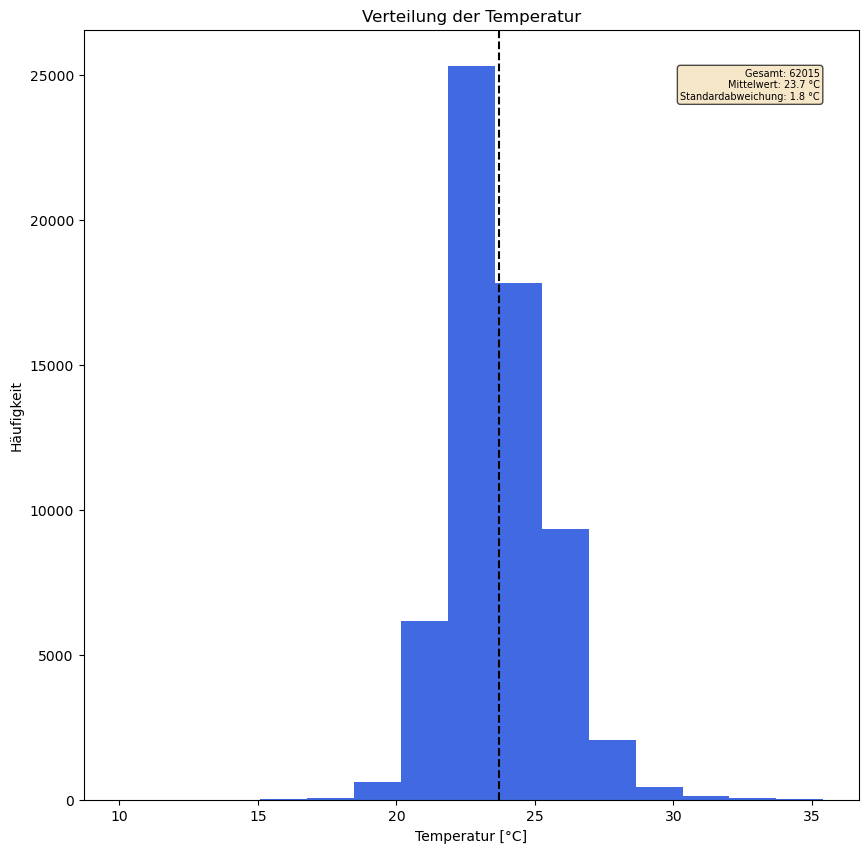

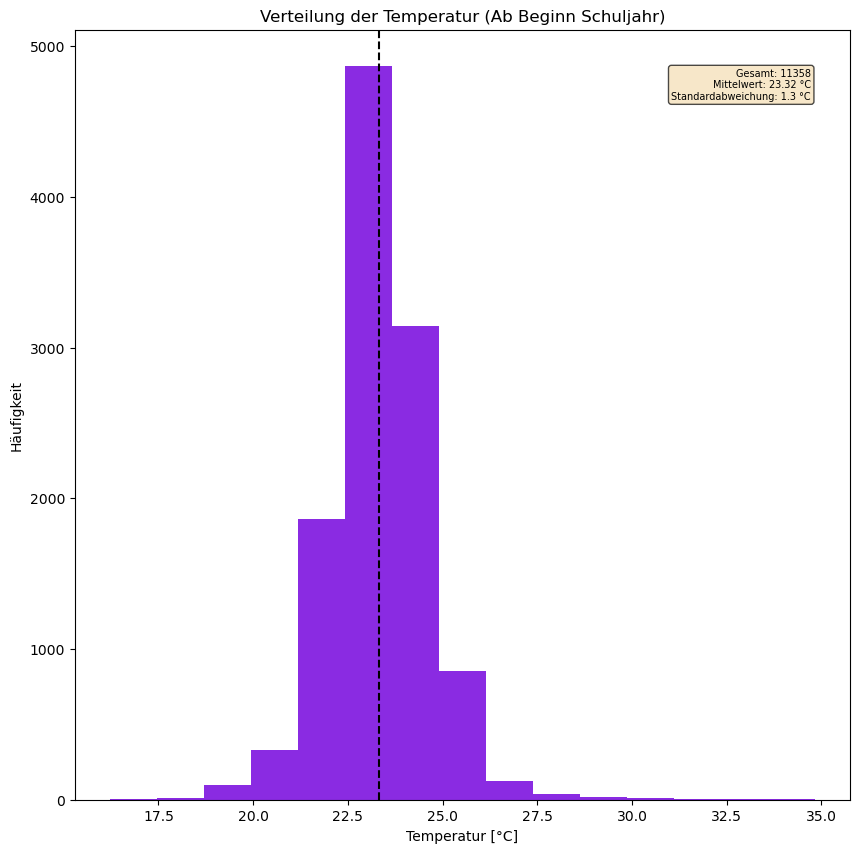

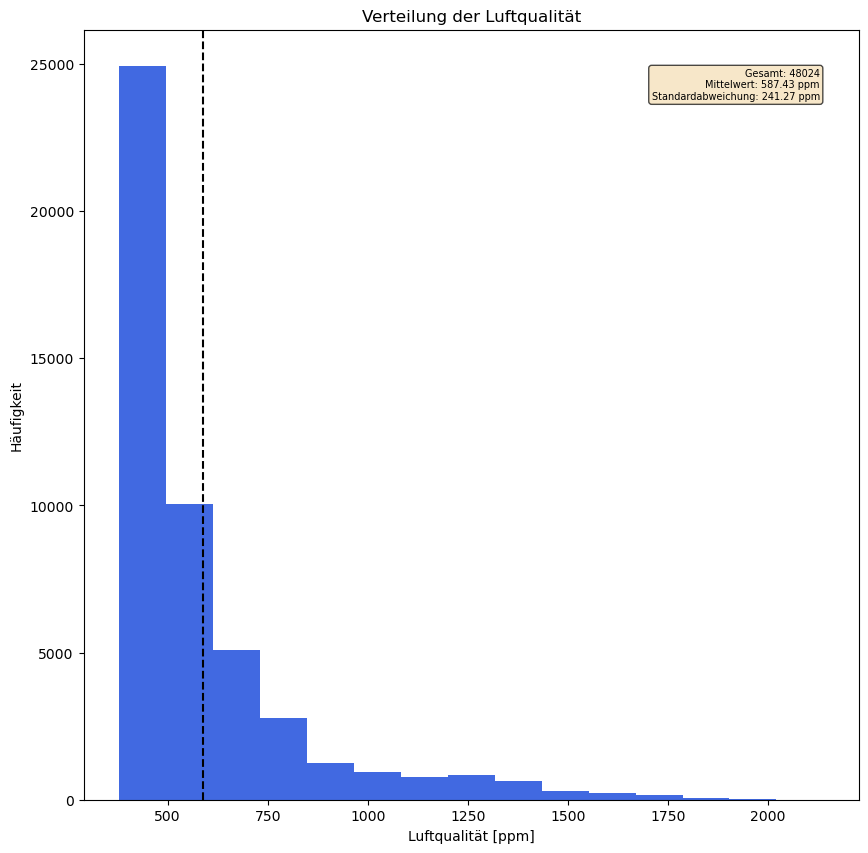

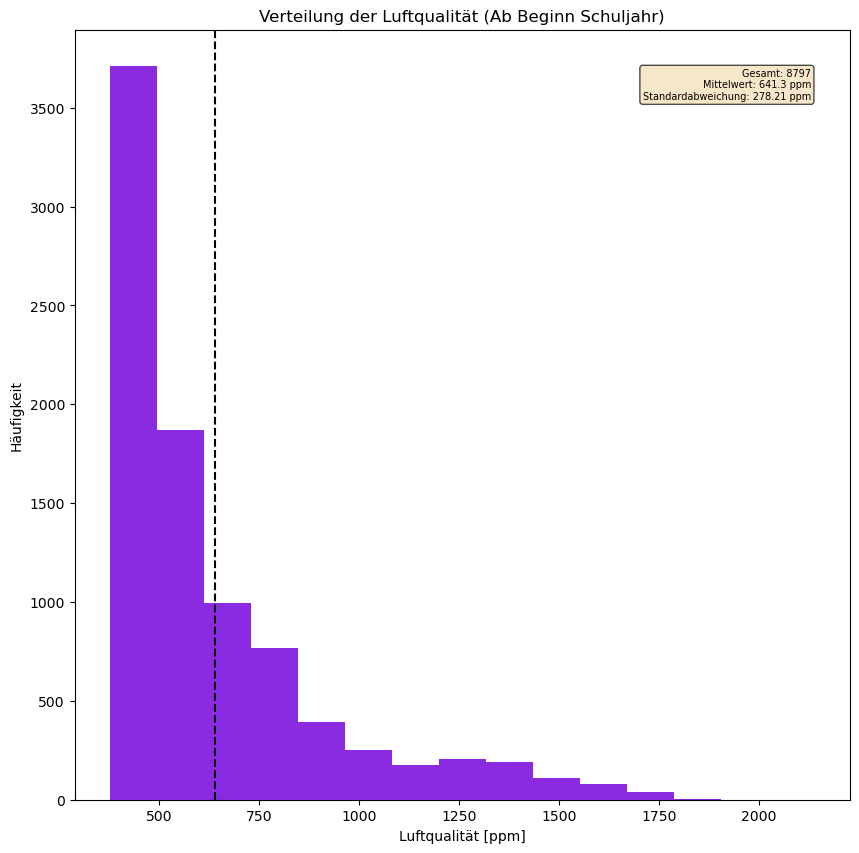

In [33]:
# Single Histogram

def plot_single_hist(rooms, measurement, unit, color, feedback_period=False):
    values = []
    for room in rooms:
        values += room.iloc[:,0].to_list()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.hist(values, bins=15, color=color)
    plt.xlabel(f'{measurement} [{unit}]')
    plt.ylabel("Häufigkeit")
    ax.axvline(np.mean(values), color='k', linestyle='dashed')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.95, 0.95,
        f"Gesamt: {len(values)}\nMittelwert: {round(np.mean(values), 2)} {unit}\nStandardabweichung: {round(np.std(values), 2)} {unit}",
        transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right', bbox=props, fontsize=7)

    if feedback_period:
        plt.title("Verteilung der " + measurement + " (Ab Beginn Schuljahr)")
        plt.savefig("../plots/distribution_plots/Histogram " + measurement + " feedback period.png")
    else:
        plt.title("Verteilung der " + measurement)
        plt.savefig("../plots/distribution_plots/Histogram " + measurement + ".png")
    plt.show()

for rooms, rooms_feedback_period, measurement, unit in zip(rooms_data, rooms_data_feedback_period, titles, units):
    plot_single_hist(rooms, measurement, unit, 'royalblue') # Total room data period
    plot_single_hist(rooms_feedback_period, measurement, unit, 'blueviolet', feedback_period=True) # Feedback data period

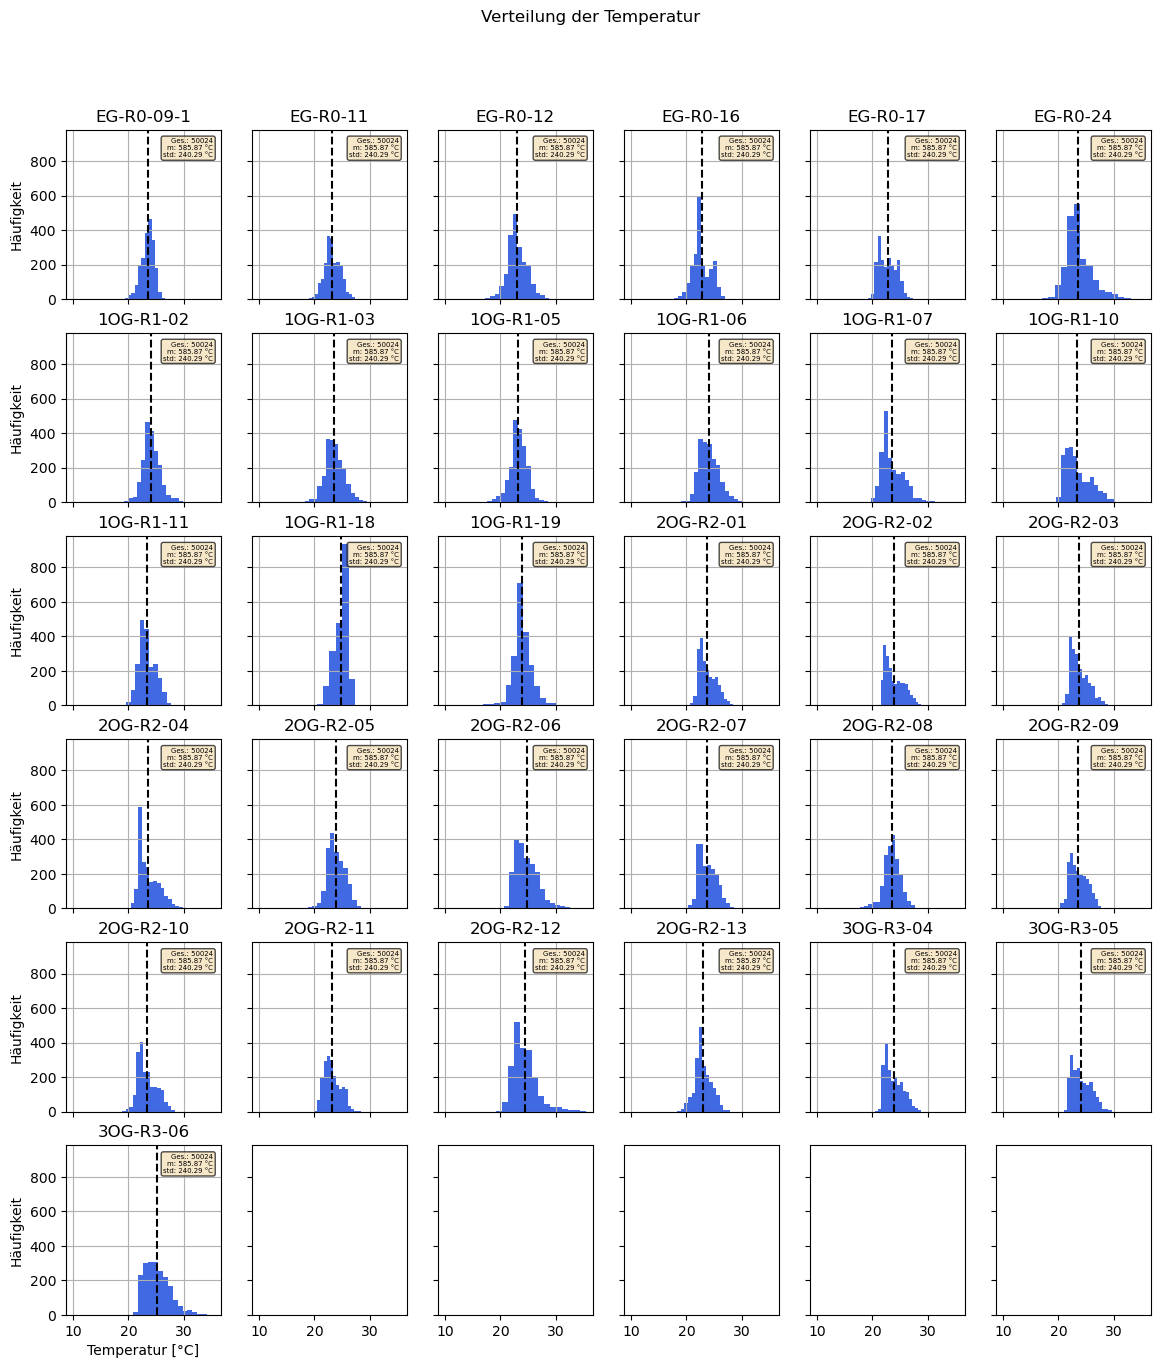

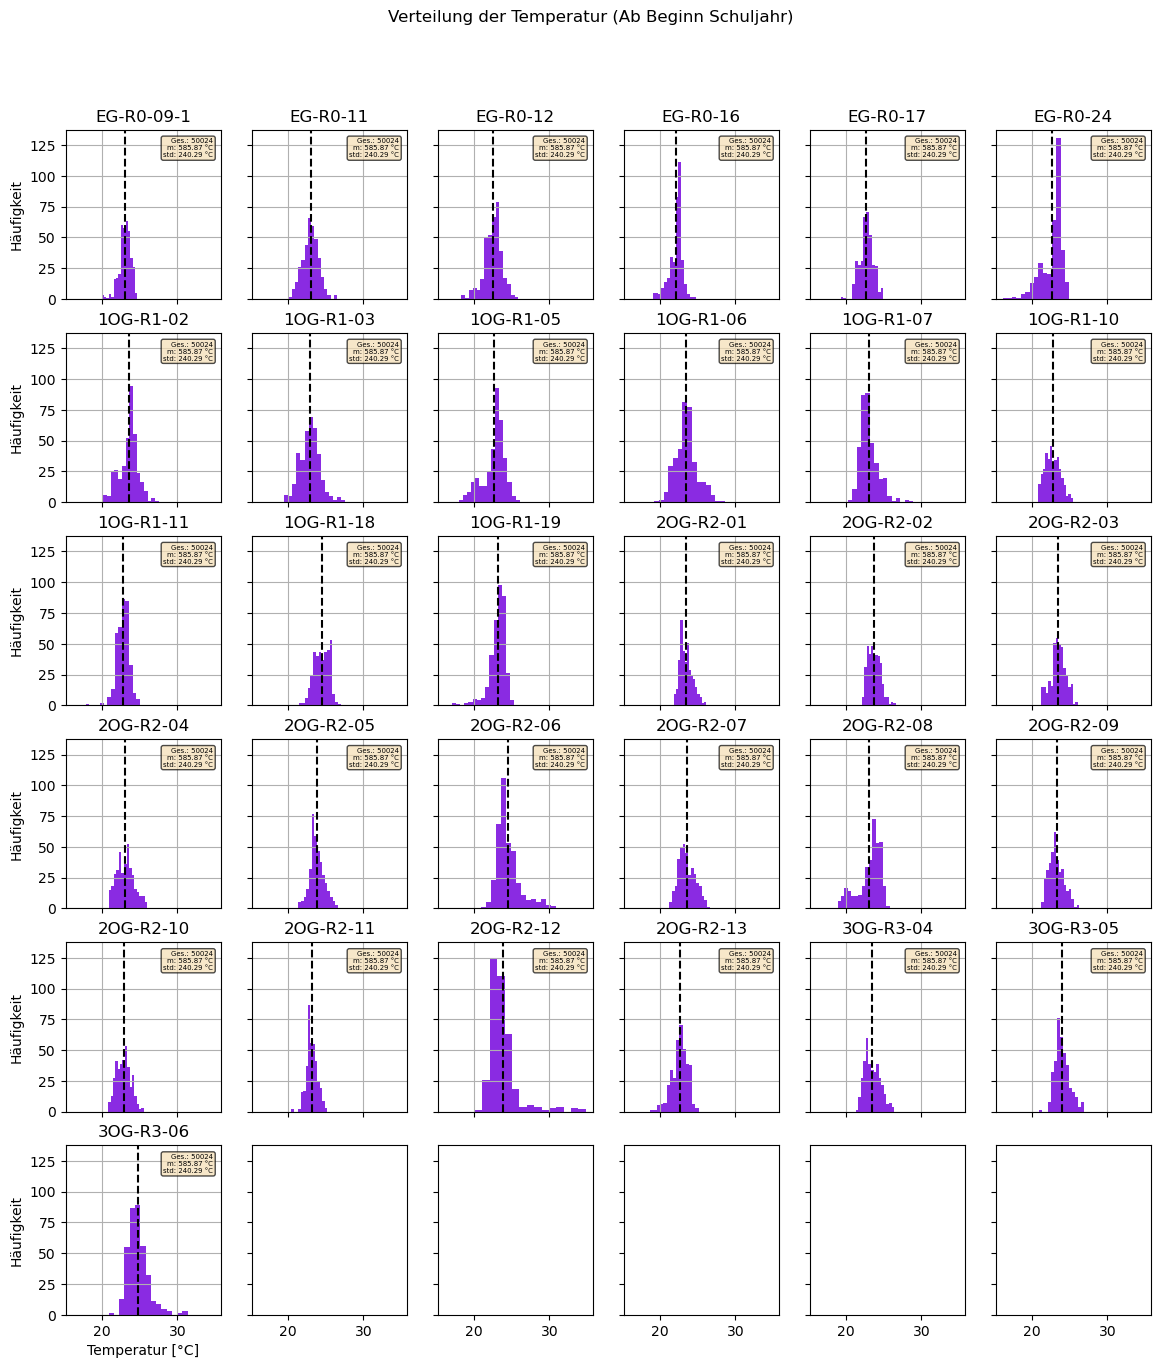

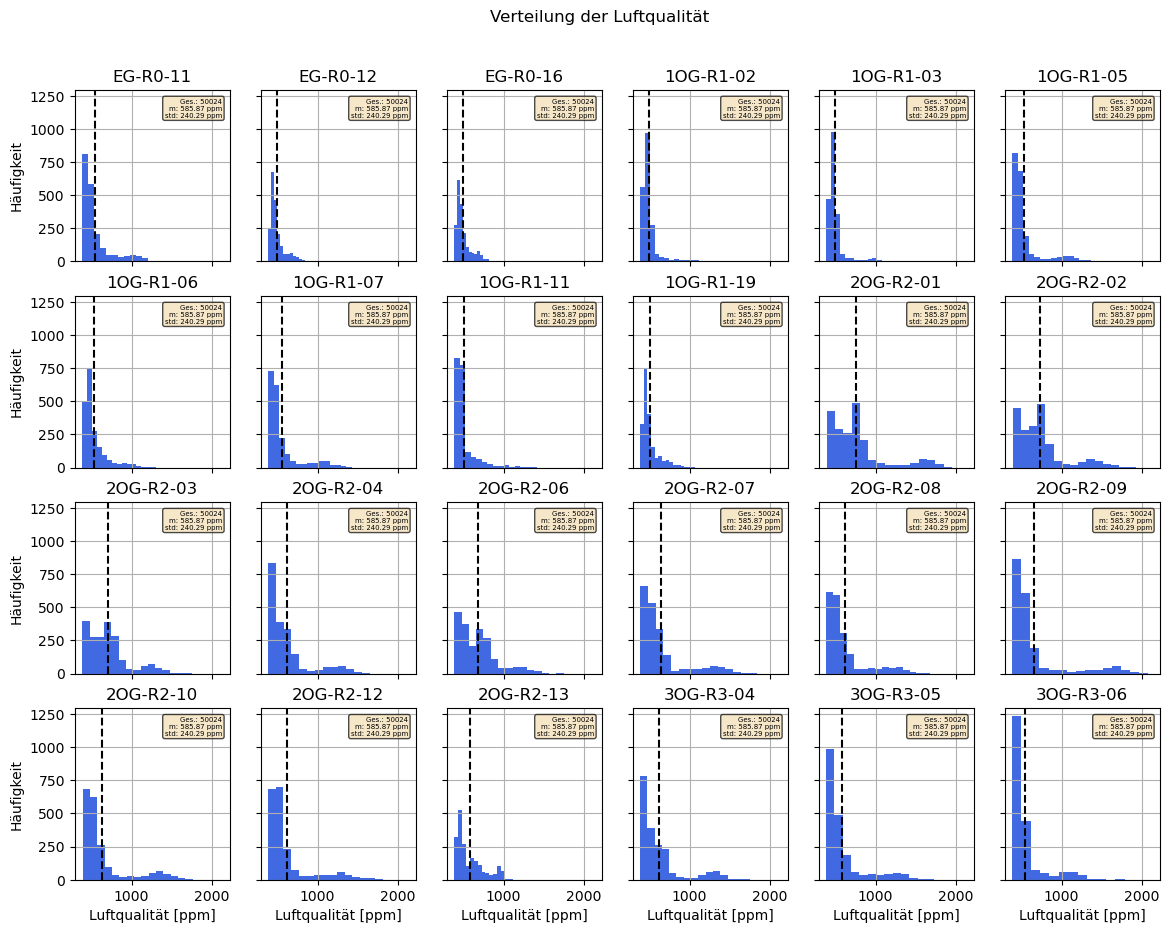

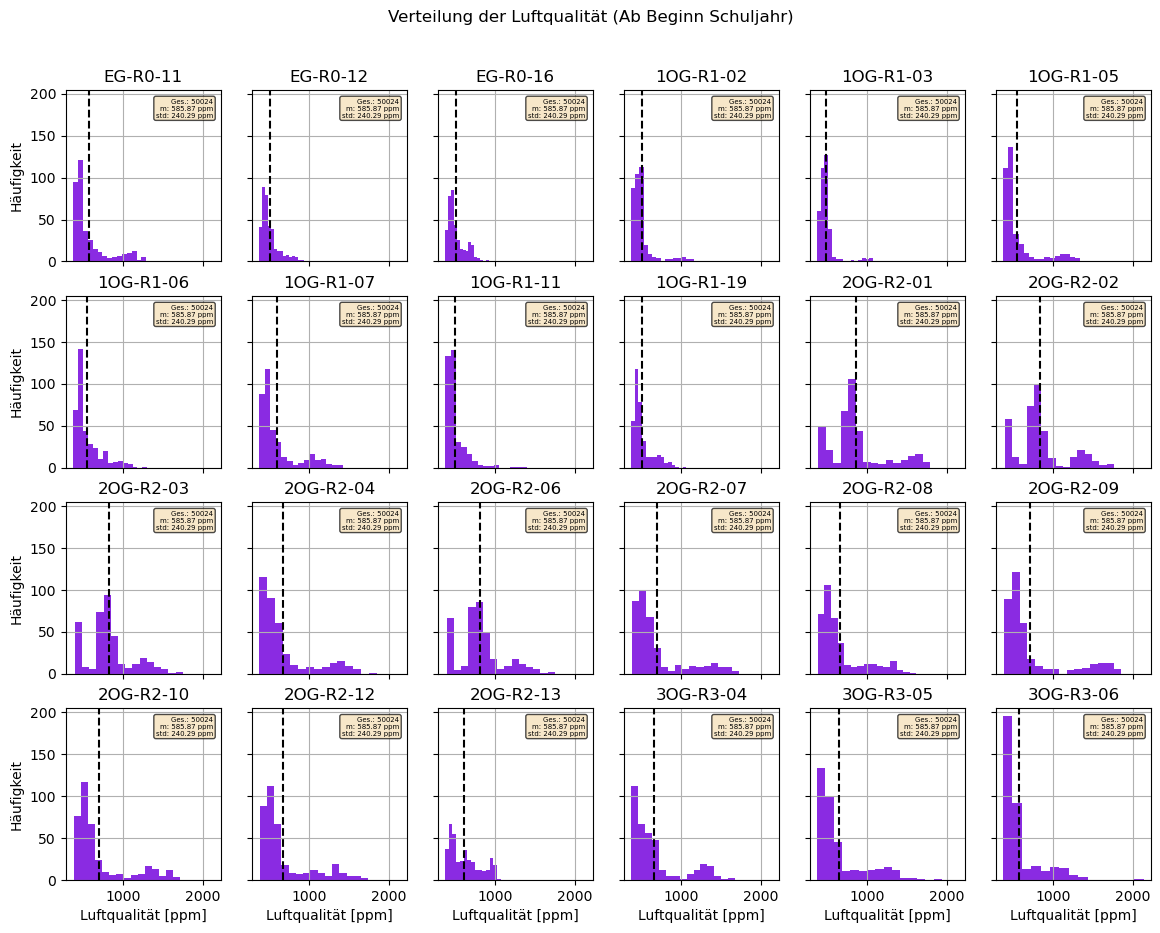

In [38]:
# Multiple Histograms

n_rows_list = [6, 4]

def plot_multiple_hist(rooms, room_names, measurement, unit, color, n_rows, feedback_period=False):
    fig, axs = plt.subplots(nrows=n_rows, ncols=6, figsize=(14, n_rows*2.5), sharex=True, sharey=True)
    fig.subplots_adjust(top=0.9)
    fig.add_gridspec(3, hspace=5)
    for it, (room, name) in enumerate(zip(rooms, room_names)):
        current_row = int(it / 6)
        current_col = it % 6
        ax = axs[current_row, current_col]
        ax.hist(room[name], bins=15, color=color, label=name)
        ax.axvline(np.mean(room[name]), color='k', linestyle='dashed')
        ax.grid()
        ax.set_title(name)
        ax.set_xlabel(f'{measurement} [{unit}]')
        ax.set_ylabel("Häufigkeit")
        ax.label_outer()
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.95, 0.95,
            f"Ges.: {len(values)}\nm: {round(np.mean(values), 2)} {unit}\nstd: {round(np.std(values), 2)} {unit}",
            transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right', bbox=props, fontsize=5)

    if feedback_period:
        plt.suptitle("Verteilung der " + measurement + " (Ab Beginn Schuljahr)")
        plt.savefig("../plots/distribution_plots/Histogram Subplots " + measurement + " feedback period.png")
    else:
        plt.suptitle("Verteilung der " + measurement)
        plt.savefig("../plots/distribution_plots/Histogram Subplots " + measurement + ".png")

    plt.show()

for rooms, rooms_feedback_period, room_names, measurement, unit, n_rows in zip(rooms_data, rooms_data_feedback_period, names_list, titles, units, n_rows_list):
    plot_multiple_hist(rooms, room_names, measurement, unit, 'royalblue', n_rows)
    plot_multiple_hist(rooms_feedback_period, room_names, measurement, unit, 'blueviolet', n_rows, feedback_period=True)

# Violin Plot

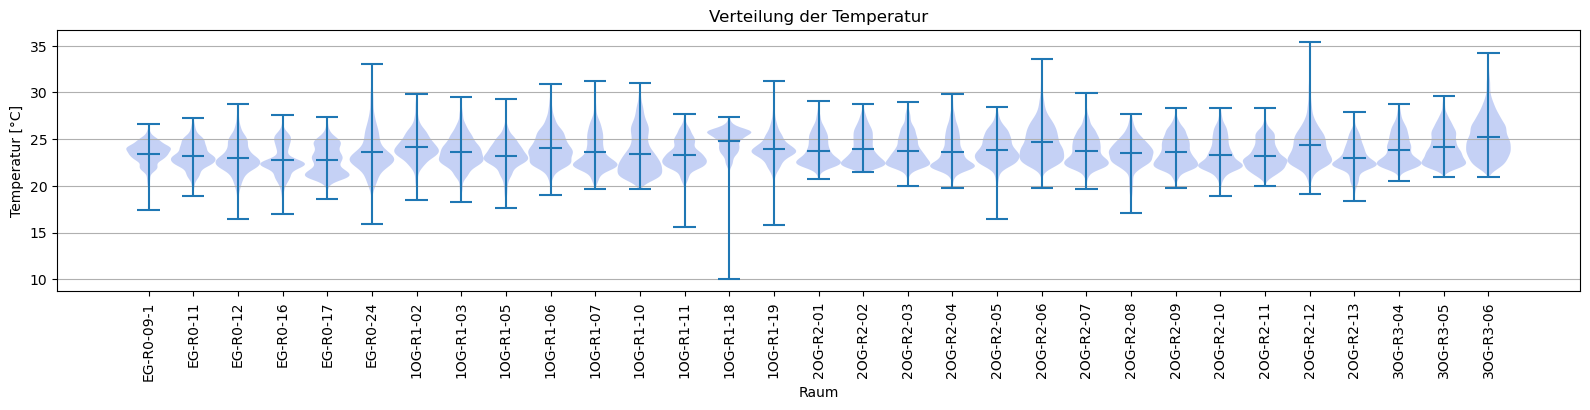

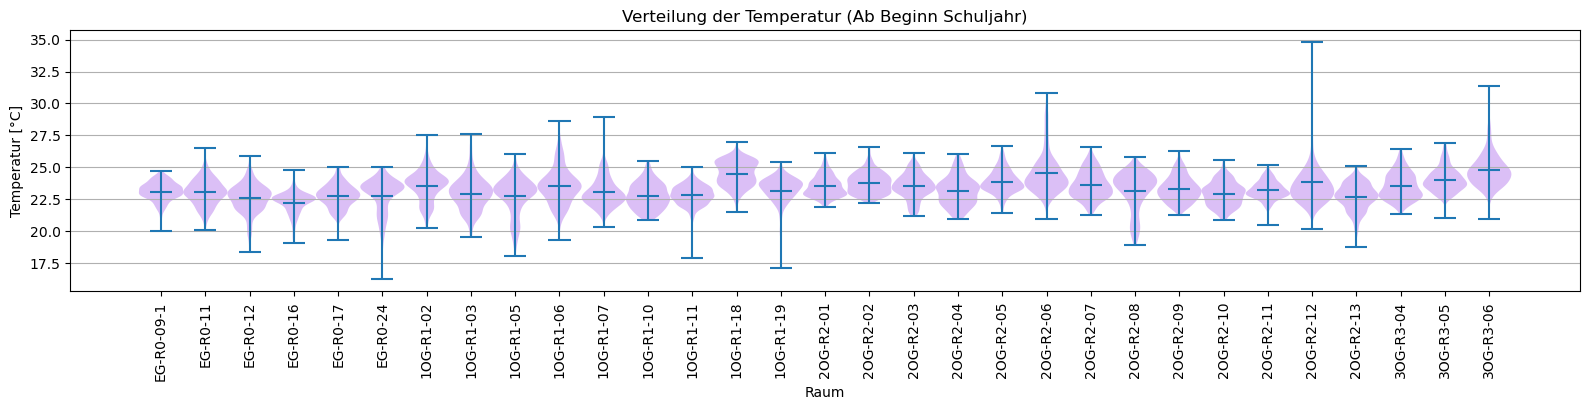

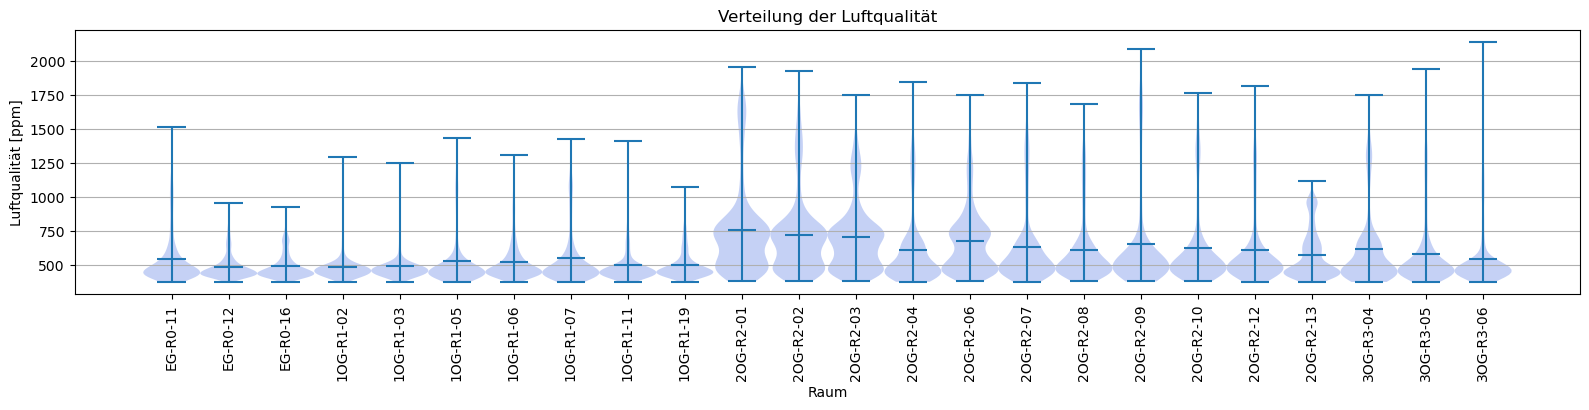

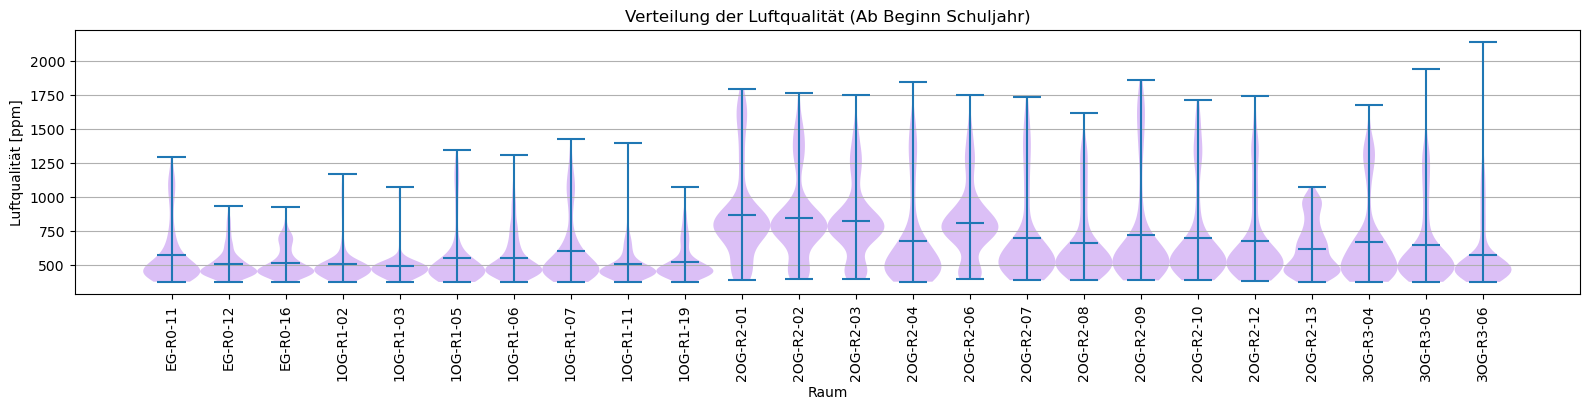

In [63]:
def plot_violin(rooms, measurement, unit, color, feedback_period=False):
    fig, ax = plt.subplots(figsize=(16, 4))

    rooms_list = []
    room_names = []
    for room in rooms:
        rooms_list.append(room.iloc[:,0].to_list())
        room_names.append(room.columns[0])

    parts = ax.violinplot(rooms_list, widths=1, showmeans=True, showextrema=True)
    for part in parts['bodies']:
        part.set_facecolor(color)
    ax.set_xlabel('Raum')
    ax.set_ylabel(f'{measurement} [{unit}]')
    ax.set_xticks(ticks=np.arange(1, len(rooms_list)+1), labels=room_names, rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()

    if feedback_period:
        ax.set_title("Verteilung der " + measurement + " (Ab Beginn Schuljahr)")
        plt.savefig("../plots/distribution_plots/Distribution " + measurement + " feedback period.png")
    else:
        ax.set_title("Verteilung der " + measurement)
        plt.savefig("../plots/distribution_plots/Distribution " + measurement + ".png")

    plt.show()

for rooms, rooms_feedback_period, room_names, measurement, unit in zip(rooms_data, rooms_data_feedback_period, names_list, titles, units):
    plot_violin(rooms, measurement, unit, 'royalblue')
    plot_violin(rooms_feedback_period, measurement, unit, 'blueviolet', feedback_period=True)

# Values by hour of the day

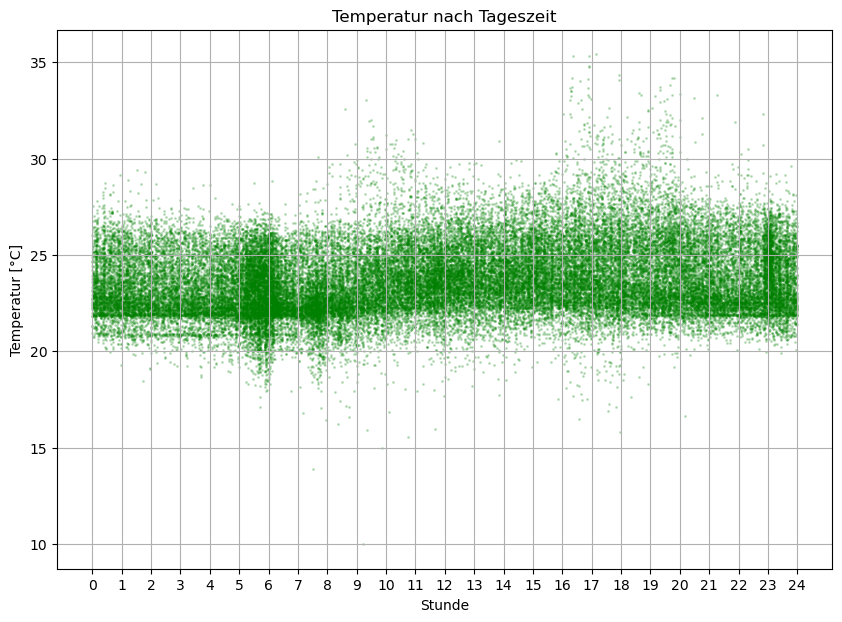

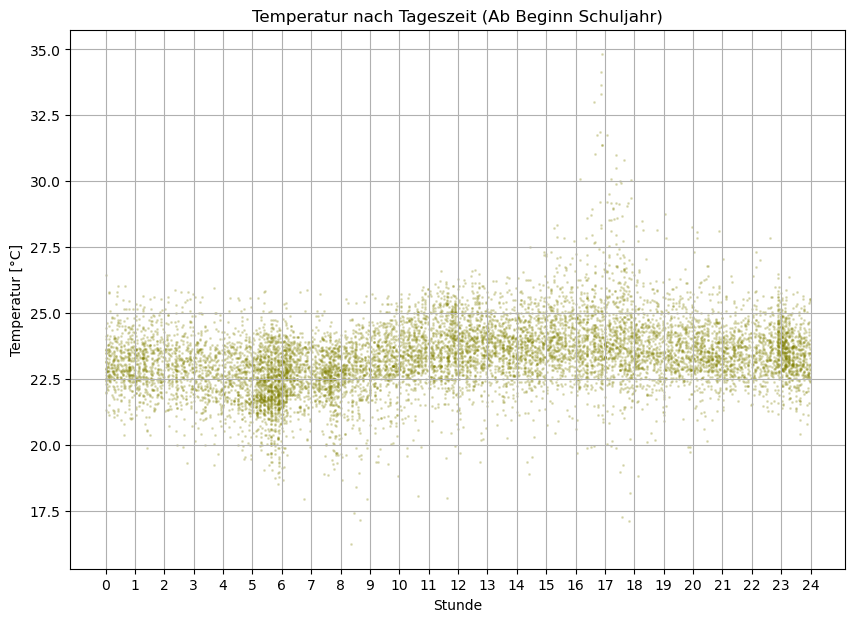

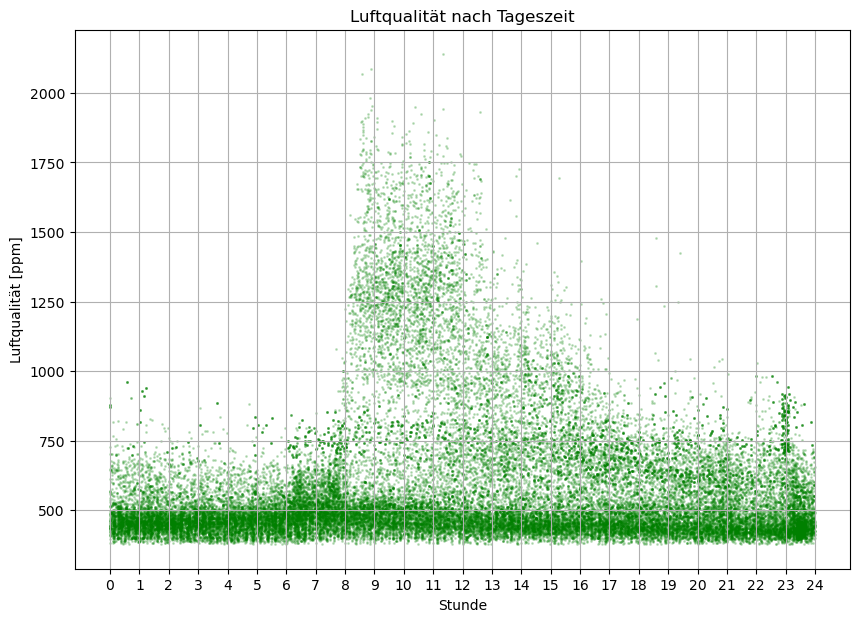

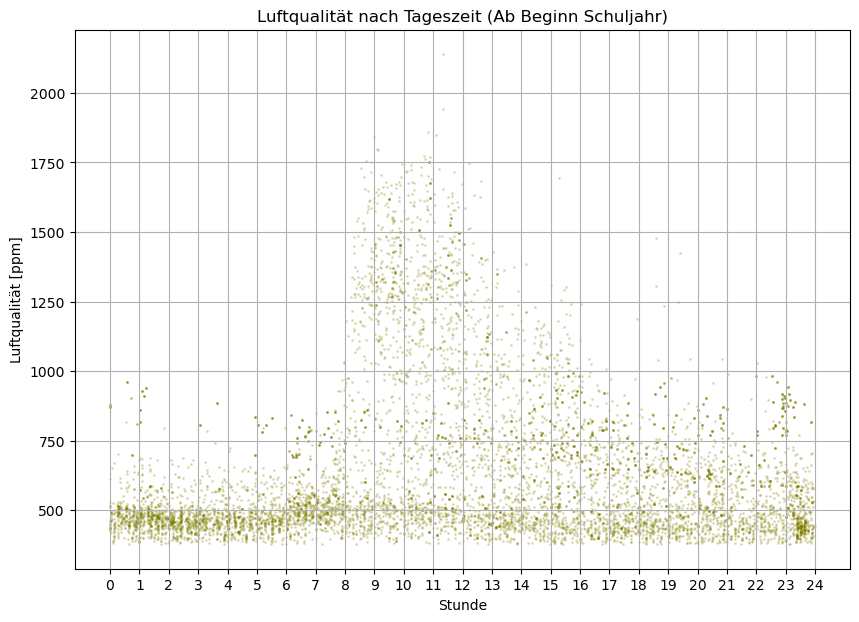

In [66]:
# Single Scatterplot

def plot_single_scatter(rooms, measurement, unit, color, feedback_period=False):
    fig, ax = plt.subplots(figsize=(10, 7))

    for room in rooms:
        ax.scatter(room.loc[:, 'Minute'], room.iloc[:,[0]], c=color, s=1.2, alpha=0.2)
    plt.title(f"{measurement} nach Tageszeit")
    plt.xlabel("Stunde")
    ax.set_xticks(np.arange(0, 25) * 60, np.arange(0, 25))
    plt.ylabel(f'{measurement} [{unit}]')
    plt.grid()

    if feedback_period:
        ax.set_title(f"{measurement} nach Tageszeit (Ab Beginn Schuljahr)")
        plt.savefig("../plots/room_values_by_hour/" + measurement + "_by_datetime_feedback period.png")
    else:
        ax.set_title(f"{measurement} nach Tageszeit")
        plt.savefig("../plots/room_values_by_hour/" + measurement + "_by_datetime.png")

    plt.show()

for rooms, rooms_feedback_period, measurement, unit in zip(rooms_data, rooms_data_feedback_period, titles, units):
    plot_single_scatter(rooms, measurement, unit, 'green')
    plot_single_scatter(rooms_feedback_period, measurement, unit, 'olive', feedback_period=True)

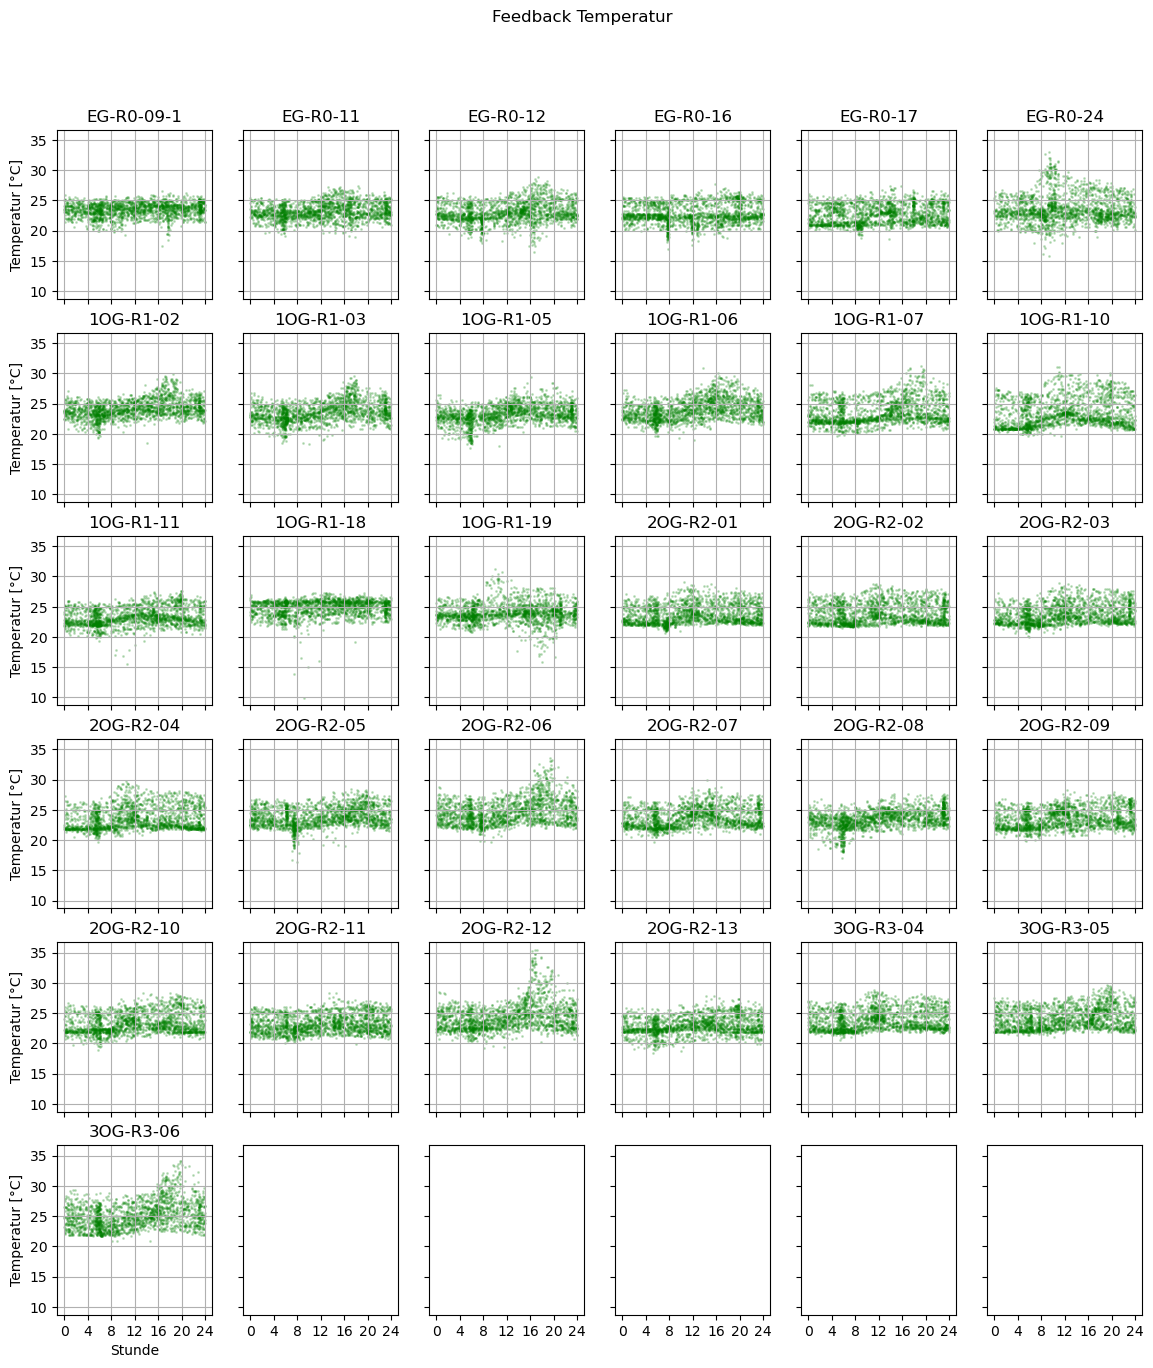

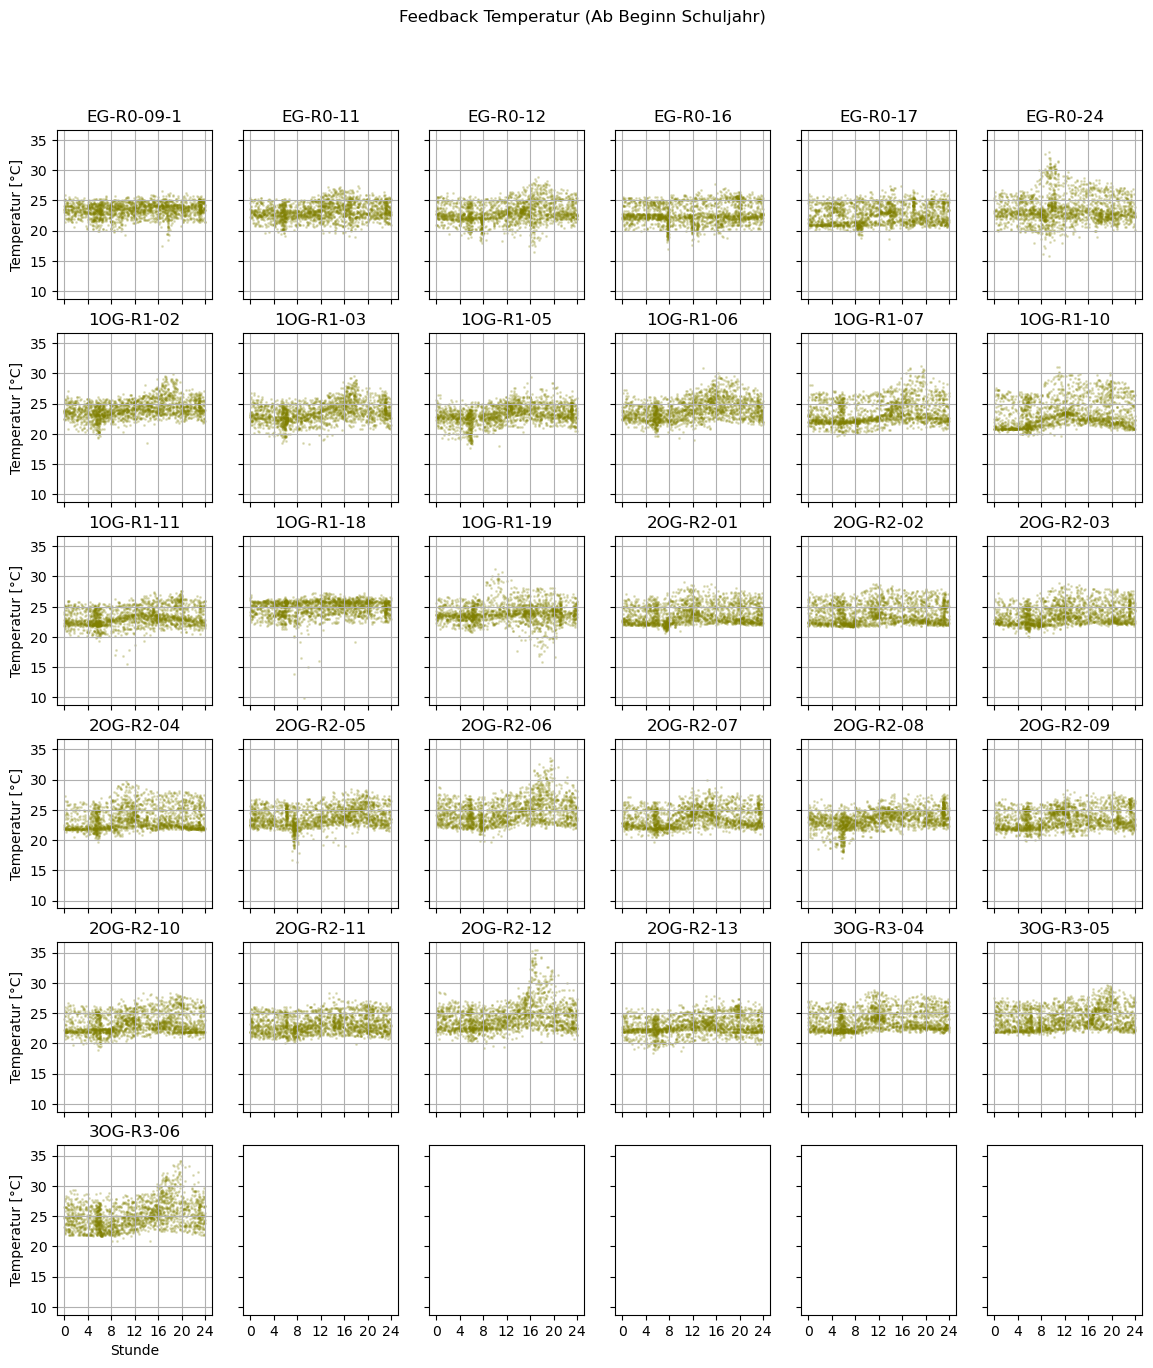

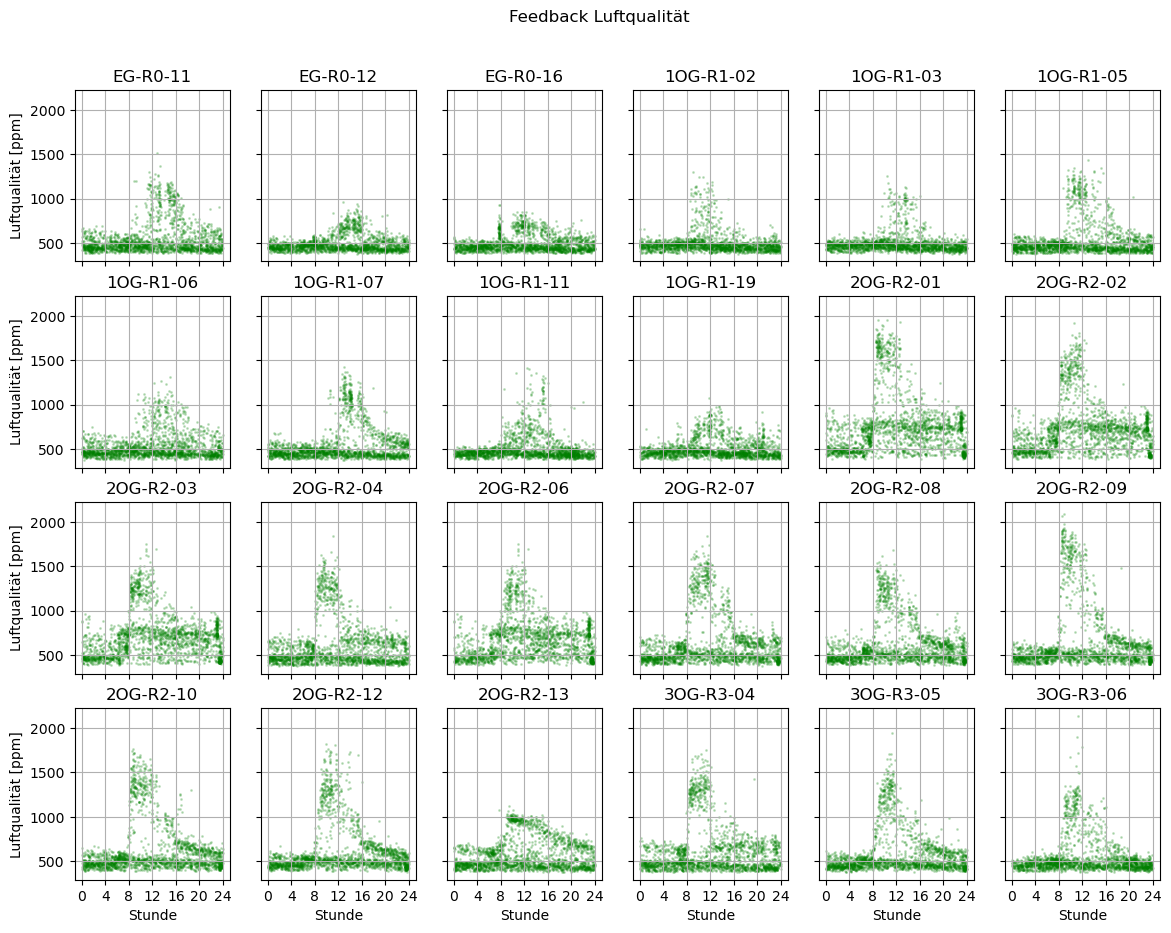

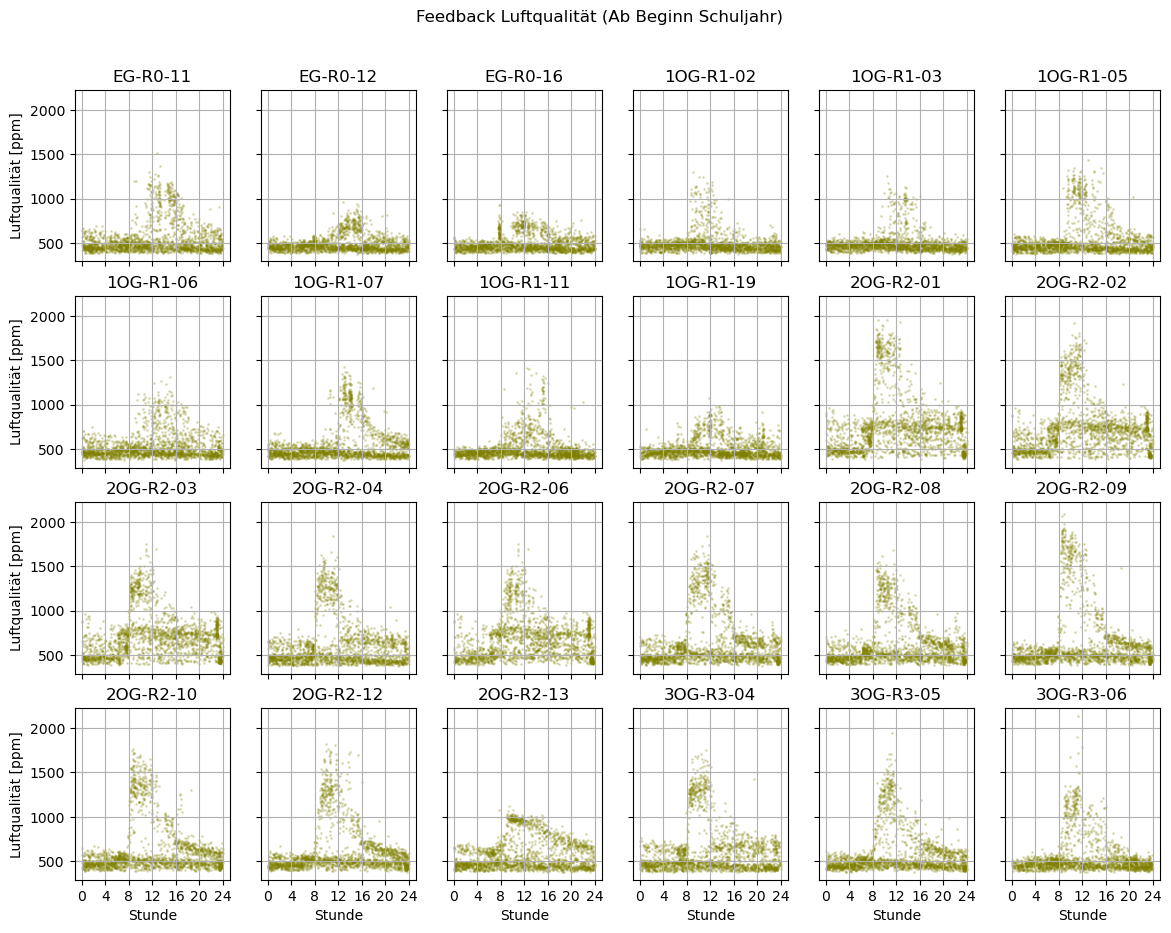

In [68]:
n_rows_list = [6, 4]

def plot_multiple_scatter(rooms, measurement, unit, n_rows, color, feedback_period=False):
    fig, axs = plt.subplots(nrows=n_rows, ncols=6, figsize=(14, n_rows*2.5), sharex=True, sharey=True)
    fig.subplots_adjust(top=0.9)
    fig.add_gridspec(3, hspace=5)
    
    for it, room in enumerate(rooms):
        current_row = int(it / 6)
        current_col = it % 6
        ax = axs[current_row, current_col]
        ax.scatter(room.loc[:, 'Minute'], room.iloc[:,[0]], c=color, s=1.2, alpha=0.2)
        ax.set_title(room.iloc[:,0].name)
        ax.set_xlabel("Stunde")
        ax.set_ylabel(f'{measurement} [{unit}]')
        ax.set_xticks(np.arange(0, 25, 4) * 60, np.arange(0, 25, 4))
        ax.label_outer()
        ax.grid()

    if feedback_period:
        plt.suptitle(f"Feedback {measurement} (Ab Beginn Schuljahr)")
        plt.savefig("../plots/room_values_by_hour/" + measurement + "_by_datetime_Subplots_feedback period.png")
    else:
        plt.suptitle(f"Feedback {measurement}")
        plt.savefig("../plots/room_values_by_hour/" + measurement + "_by_datetime_Subplots.png")

    plt.show()

for rooms, measurement, unit, n_rows in zip(rooms_data, titles, units, n_rows_list):
    plot_multiple_scatter(rooms, measurement, unit, n_rows, 'green')
    plot_multiple_scatter(rooms, measurement, unit, n_rows, 'olive', feedback_period=True)